### Given the complexity of neural networks, we mostly treat them as black box, but what do the layers learn that they are so good at the predictions? In this notebook, we will try to mock up what do different layers in a convolutional neural networks learn. We will use an existing trained model.

##### Going off track at the very beginning, we usually use trained models for transfer learning. Note that the reason transfer learning works is because bottom layers ( closer to the input ) learn basic features that are common across different learning problems, however the top layers learn things specific to your use case. This is why we freeze bottom few layers and instead train top layers when doing transfer learning!

##### I am going to try two ways! One is to show the output of each layer and its filters for a given image. But what really made me to try this out is the second way which is very interesting. Instead of providing the model with input image, we 'optimize' pixel values of a random image so that we can maximize activations of given layer! This is how we generate images that represent what any given neural network feature map has learnt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras.applications.vgg16 as vgg16
import keras.preprocessing.image as image_processor
from keras.models import Model

Using TensorFlow backend.


In [2]:
original_model = vgg16.VGG16()
model_input_shape = original_model.layers[0].output.shape[1:3] #image width x height
original_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Note that as we go deeper in the network, image's width and height keeps on decreasing...while number of channels keep on increasing! This finally joined with dense layers helps us with predictions. Also note the use of maxPooling layers to reduce image dimensions!

## 1. Using outputs of layers in CNN!

In [3]:
# Which ones are convolutional layers?
convo_layers = []  #we are interested in output at these images
for i in range(len(original_model.layers)):
    layer = original_model.layers[i]
    if 'conv' in layer.name:
        convo_layers.append( layer.output )
        print(i, layer.name, layer.output.shape) #convolutional layers
#create new model with convolutional layers as outputs
new_model = Model(inputs=original_model.inputs, outputs=convo_layers)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [7]:
def feature_map_image( img_path ):
    img = image_processor.load_img( img_path, target_size=(224, 224))
    plt.imshow(img) #see the image
    img = image_processor.img_to_array(img) #image as target_size with channel dimensions too
    img = np.expand_dims(img, axis=0) #add axis for image example at the beginning
    img = vgg16.preprocess_input(img) #pass it as input
    feature_maps = new_model.predict(img) #checkout all the outputs
    return feature_maps

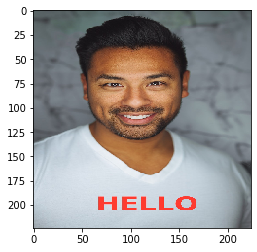

In [8]:
feature_maps = feature_map_image( '/Users/gursharan/Desktop/face.jpg' )

In [9]:
def show_features( features ):
    total_channels = features.shape[3]
    plt.figure(figsize=(16,16))
    length = int(np.sqrt( total_channels ))
    index = 1
    for _ in range(length):
        for _ in range(length):
            ax = plt.subplot(length, length, index)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow( features[0,:,:,index-1] ) #filter to show
            index = index + 1
    plt.show()

def show( image ):
    plt.figure()
    plt.imshow( image )

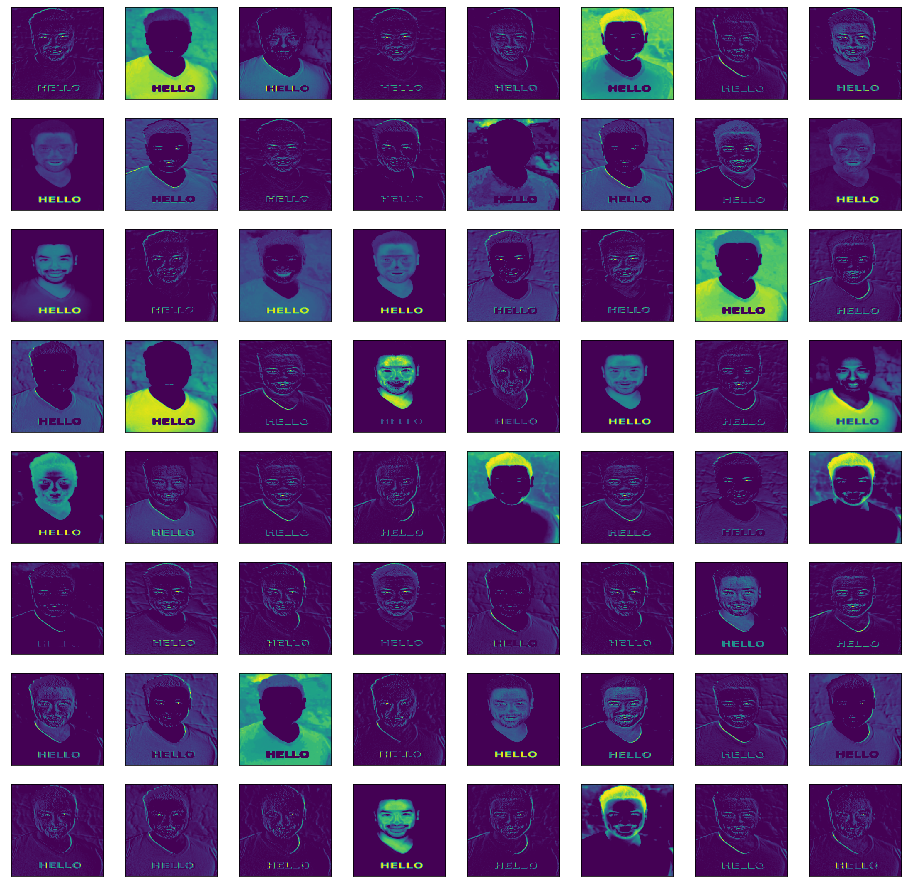

In [10]:
show_features( feature_maps[0] )

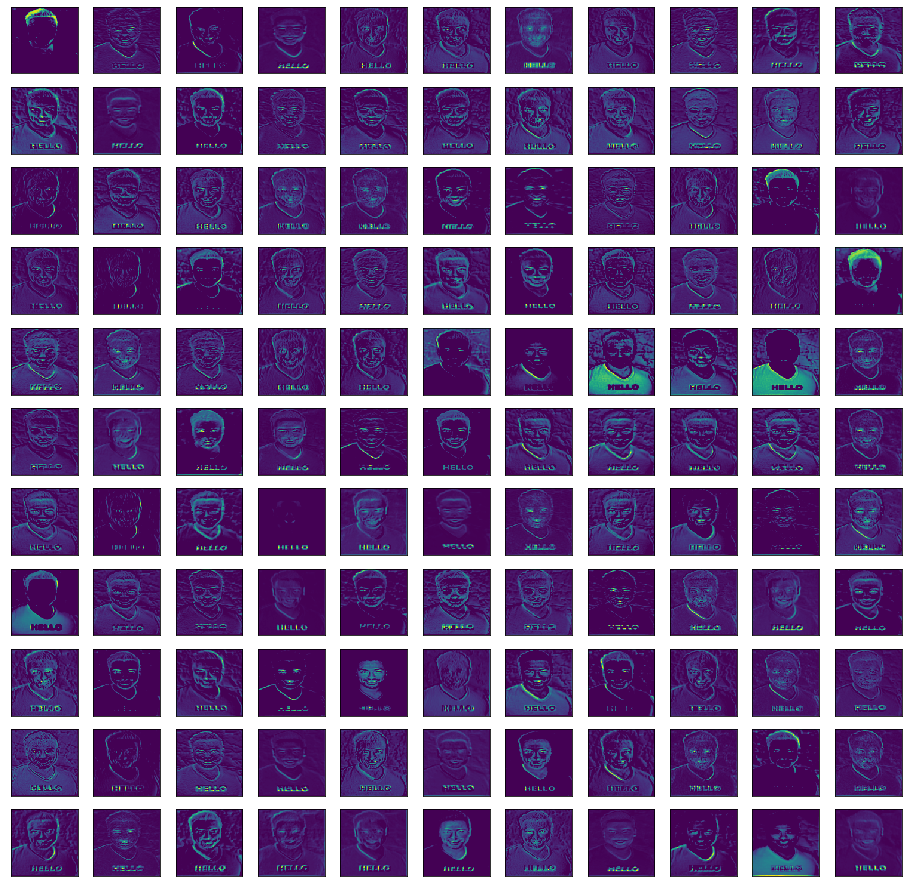

In [11]:
show_features( feature_maps[2] )

#### Let's look at some of the features that layers detect. For example in our first convoluational layer, we see two filters that detect very bright and very dark colors separately.

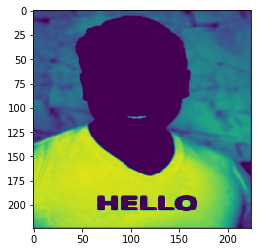

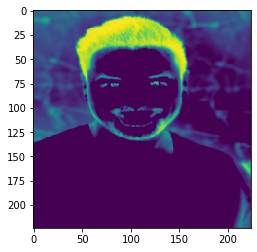

In [12]:
show(feature_maps[0][0, :, :, 25])
show(feature_maps[0][0, :, :, 39])

#### One filter in the last layer seems like face detector! Let's have a look at that and then double check that with another image of a face

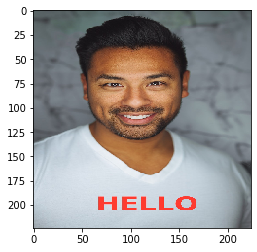

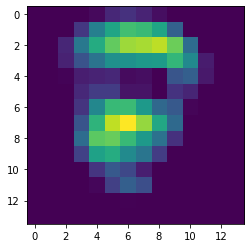

In [13]:
feature_maps = feature_map_image( '/Users/gursharan/Desktop/face.jpg' )
show( feature_maps[-1][0,:,:,220] )

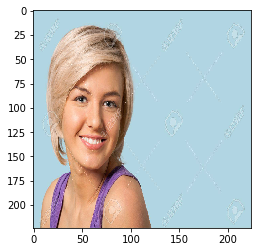

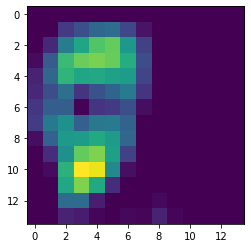

In [14]:
feature_maps_2 = feature_map_image( '/Users/gursharan/Desktop/face2.jpg' )
show( feature_maps_2[-1][0,:,:,220] )  #sounds good!!

#### This method is limited in using a sample image as model input! There is another way to actually generate an image that maximizer the activation of any filter and we can use the generate image to get idea what each filter is supposed to be looking at!